In [98]:
import logging
from tqdm import tqdm
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt
from random import randint
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

In [240]:
class MyProphet():
    def __init__(self,
                 n_changepoints=25,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8,
                 seasonality_prior_scale=10.0,
                 mcmc_samples=0,
                 k_mean=0,
                 k_sd=5,
                 m_mean=0,
                 m_sd=5,
                 sigma=0.5,
                ):
        self.n_changepoints = n_changepoints
        self.changepoints_prior_scale = changepoints_prior_scale
        self.changepoint_range = changepoint_range
        self.seasonality_prior_scale = seasonality_prior_scale
        self.mcmc_samples = mcmc_samples
        self.k_mean = k_mean
        self.k_sd = k_sd
        self.m_mean = m_mean
        self.m_sd = m_sd
        self.sigma = sigma
        
        self.model = None
        self.init_vals = None
        self.trend_params = None
        self.yearly_seasonality_params = None
        self.weekly_seasonality_params = None
        self.map_approx = None
        self.trace = None
        self.posterior = None
        
        self.data = None
        self.y_min = None
        self.y_max = None
        self.ds_min = None
        self.ds_max = None

    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        
    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        k = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        m = self.data["y"].iloc[i0] - k * self.data["t"].iloc[i0]
        delta = np.zeros(self.n_changepoints)
        self.init_vals = {"k": k, "m": m, "delta": delta, "beta_yearly": 0.0, "beta_weekly": 0.0, "sigma": 1.0}

    def _add_trend(self):
        t = np.array(self.data["t"])
        hist_size = int(np.floor(self.data.shape[0] * self.changepoint_range))
        cp_indexes = np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(int)
        s = np.array(self.data.iloc[cp_indexes]["t"].tail(-1))
    
        # * 1 casts the boolean to integers
        A = (t[:, None] > s) * 1
    
        with self.model:
            # initial growth
            k = pm.Normal("k", self.k_mean , self.k_sd, initval=self.init_vals["k"])

            changepoints_prior_scale = self.changepoints_prior_scale
            if self.changepoints_prior_scale is None:
                changepoints_prior_scale = pm.Exponential("tau", 1.5)
        
            # rate of change
            delta = pm.Laplace("delta", 0, changepoints_prior_scale, shape=self.n_changepoints, initval=self.init_vals["delta"])
            # offset
            m = pm.Normal("m", self.m_mean, self.m_sd, initval=self.init_vals["m"])
            gamma = -s * delta
            trend = pm.Deterministic("trend", (k + pyt.tensor.dot(A, delta)) * t + (m + pyt.tensor.dot(A, gamma)))

        return trend, A, s

    def _fourier_series(self, data, p=365.25, n=10):
        x = 2 * np.pi * np.arange(1, n + 1) / p
        x = x * np.array(data["t"])[:, None]
        x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
        return x

    def _get_seasonality_n_x(self, data, period):
        if period == "yearly":
            n = 10
            p = 365.25
        else:  # weekly
            n = 3
            p = 7

        # rescale the period, as t is also scaled
        p /= (self.ds_max - self.ds_min).days
            
        return n, self._fourier_series(data, p, n)

    def _add_seasonality(self, period):
        n, x = self._get_seasonality_n_x(self.data, period)
    
        with self.model:
            beta = pm.Normal(f"beta_{period}", mu=0, sigma=self.seasonality_prior_scale, shape=2 * n, initval=np.zeros(2 * n))
            
        return x, beta

    def fit(self, data):
        self.data = data.reset_index(drop=True)
        self._process_data()
        self._model_init()

        self.model = pm.Model()
        with self.model:
            trend, A, s = self._add_trend()
            x_yearly, beta_yearly = self._add_seasonality("yearly")
            x_weekly, beta_weekly = self._add_seasonality("weekly")
            trend += pyt.tensor.dot(x_yearly, beta_yearly) + pyt.tensor.dot(x_weekly, beta_weekly)
            # sigma = pm.HalfCauchy("sigma", 0.5, initval=1)
            sigma = pm.HalfNormal("sigma", self.sigma, initval=self.init_vals["sigma"])
            obs = pm.Normal("obs", mu=trend, sigma=sigma, observed=self.data["y"])
            
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=False, maxeval=1e4)
            else:
                self.trace = pm.sample(self.mcmc_samples, return_inferencedata=True, cores=6, chains=4)
                self.posterior = pm.sample_posterior_predictive(trace=self.trace)

        self.trend_params = (trend, A, s)
        self.yearly_seasonality_params = (x_yearly, beta_yearly)
        self.weekly_seasonality_params = (x_weekly, beta_weekly)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _plot_predictions(self, future, y_true=None):
        date = future["ds"].dt.to_pydatetime()
        plt.figure(figsize=(16, 3*6))
        b = 411
        plt.subplot(b)
        plt.title("Predictions")
        plt.plot(date, future["yhat"], lw=0.5)
        plt.scatter(date[:len(self.data)], self.data["y"] * self.y_max, s=0.5, color="black")

        if y_true is not None:
            plt.scatter(date[len(self.data):], y_true, s=0.5, color="green")

        plt.subplot(b + 1)
        plt.title("Trend")
        plt.plot(date, future["trend"], lw=0.5)
        # plt.scatter(date[:len(self.data)], self.data["y"] * self.y_max, s=0.5, color="black")

    def _make_future_df(self, days):
        future = pd.DataFrame({
            "ds": pd.DatetimeIndex(pd.concat((
                self.data["ds"], 
                pd.date_range(self.ds_max, self.ds_max + pd.Timedelta(days, "D"), inclusive="right").to_series(),
            )))
        })
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future
    
    def _predict_map(self, days, y_true=None, plot=False):
        trend, A, s = self.trend_params
        history_points = self.data.shape[0]
        probability_changepoint = self.n_changepoints / history_points
        future = self._make_future_df(days)
        
        _, x_yearly = self._get_seasonality_n_x(future, "yearly")
        _, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        yearly_posterior = self._det_seasonality_posterior(self.map_approx["beta_yearly"], x_yearly) * self.y_max
        weekly_posterior = self._det_seasonality_posterior(self.map_approx["beta_weekly"], x_weekly) * self.y_max
        
        trend_forecast = []
        future_t = np.array(future["t"])
        
        # new_changepoints = future["t"][future["t"] > 1].values
        # sample = np.random.random(new_changepoints.shape)
        # new_changepoints = new_changepoints[sample <= probability_changepoint]
        # new_s = np.r_[s, new_changepoints]
        # tau = self.map_approx["tau"] if self.changepoints_prior_scale is None else self.changepoints_prior_scale
        # new_delta = np.r_[self.map_approx["delta"], stats.laplace(0, tau).rvs(new_changepoints.shape[0])]
        # new_A = (future_t[:, None] > new_s) * 1

        # trend_forecast = np.array((
        #     (self.map_approx["k"] + np.dot(new_A, new_delta)) * future["t"] + 
        #     (self.map_approx["m"] + np.dot(new_A, (-new_s * new_delta)))
        # ) * self.y_max)

        tau = self.map_approx["tau"] if self.changepoints_prior_scale is None else self.changepoints_prior_scale
        new_delta = self.map_approx["delta"]
        new_A = (future_t[:, None] > s) * 1
        
        trend_forecast = np.array((
            (self.map_approx["k"] + np.dot(new_A, new_delta)) * future["t"] + 
            (self.map_approx["m"] + np.dot(new_A, (-s * new_delta)))
        ) * self.y_max)

        future["trend"] = trend_forecast
        future["yearly"] = yearly_posterior
        future["weekly"] = weekly_posterior
        future["yhat"] = trend_forecast + yearly_posterior + weekly_posterior

        if plot:
            self._plot_predictions(future, y_true)
            
        return future

    def _predict_mcmc(self, days, y_true=None, plot=False):
        _, _, s = self.trend_params
        history_points = df.shape[0]
        probability_changepoint = self.n_changepoints / history_points
        future = self._make_future_df(days)

        yearly_n, x_yearly = self._get_seasonality_n_x(future, "yearly")
        weekly_n, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        beta_yearly = self.trace["posterior"]["beta_yearly"].to_numpy().mean(0)
        beta_weekly = self.trace["posterior"]["beta_weekly"].to_numpy().mean(0)
        delta = self.trace["posterior"]["delta"].mean(["chain", "draw"])
        k = self.trace["posterior"]["k"].mean().to_numpy()
        m = self.trace["posterior"]["m"].mean().to_numpy()
        
        trend_forecast = []
        tau = self.trace["posterior"]["tau"].mean() if self.changepoints_prior_scale is None else self.changepoints_prior_scale
        
        future_t = np.array(future["t"])
        
        yearly_posterior = self._det_seasonality_posterior(beta_yearly, x_yearly) * self.y_max
        weekly_posterior = self._det_seasonality_posterior(beta_weekly, x_weekly) * self.y_max
        
        for n in range(self.mcmc_samples):
            new_changepoints = future["t"][future["t"] > 1].values
            sample = np.random.random(new_changepoints.shape)
            new_changepoints = new_changepoints[sample <= probability_changepoint]
            new_delta = np.r_[delta, stats.laplace(0, tau).rvs(new_changepoints.shape[0])]
            new_s = np.r_[s, new_changepoints]
            new_A = (future_t[:, None] > new_s) * 1
            trend_forecast.append(((k + np.dot(new_A, new_delta)) * future['t']  + (m + np.dot(new_A, (-new_s * new_delta)))) * df['y'].max())   
            
        trend_forecast = np.array(trend_forecast)
        
        future["yhat"] = (trend_forecast + yearly_posterior.T + weekly_posterior.T).mean(0)

        if plot:
            self._plot_predictions(future, y_true)
        
        return future

class MyProphetWrapper():
    def __init__(self,
                 n_changepoints=25,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8,
                 seasonality_prior_scale=10.0,
                 mcmc_samples=0,
                 k_mean=0,
                 k_sd=5,
                 m_mean=0,
                 m_sd=5,
                 sigma=0.5,
                ):
        self.n_changepoints = n_changepoints
        self.changepoints_prior_scale = changepoints_prior_scale
        self.changepoint_range = changepoint_range
        self.seasonality_prior_scale = seasonality_prior_scale
        self.mcmc_samples = mcmc_samples
        self.k_mean = k_mean
        self.k_sd = k_sd
        self.m_mean = m_mean
        self.m_sd = m_sd
        self.sigma = sigma

    def _calculate_metrics(self, ys, yhats, horizon):
        metrics = {"horizon": [], "mse": [], "rmse": [], "mae": [], "mape": []}

        for k in tqdm(range(horizon)):
            y_true = [y[y["day_idx"] == k]["y"].values[0] for y in ys if k in y["day_idx"].values]
            y_pred = [y[y["day_idx"] == k]["y"].values[0] for y in yhats if k in y["day_idx"].values]
            
            metrics["horizon"].append(k + 1)
            metrics["mse"].append(mean_squared_error(y_true, y_pred))
            metrics["rmse"].append(root_mean_squared_error(y_true, y_pred))
            metrics["mae"].append(mean_absolute_error(y_true, y_pred))
            metrics["mape"].append(mean_absolute_percentage_error(y_true, y_pred))

        return pd.DataFrame.from_dict(metrics)

    def test_prophet(self, df, window=730, horizon=365, extend_window=False, limit=None):
        yhats = []
        ys = []

        l = len(df) - window - horizon - 1
        if limit is not None:
            l = limit
        
        for start in tqdm(range(l)):
            model = Prophet(
                n_changepoints=self.n_changepoints,
                changepoint_prior_scale=self.changepoints_prior_scale,
                changepoint_range=self.changepoint_range,
                seasonality_prior_scale=self.seasonality_prior_scale,
            )

            if extend_window:
                model.fit(df[:start + window])
            else:
                model.fit(df[start:start + window])

            future = model.make_future_dataframe(periods=horizon, include_history=False)
            
            y = df[start + window:start + window + horizon].copy()
            y["ds"] = pd.to_datetime(y["ds"])
            yhat = model.predict(future)
        
            y = y[y["ds"].isin(yhat["ds"])]
            yhat = yhat[yhat["ds"].isin(y["ds"])]
        
            y["day_idx"] = (y["ds"] - y["ds"].min()).dt.days
            ys.append(y)
        
            yhat["day_idx"] = (yhat["ds"] - yhat["ds"].min()).dt.days
            yhat["y"] = yhat["yhat"]
            yhat.drop(yhat.columns.difference(["ds", "y", "day_idx"]), axis=1, inplace=True)
            yhats.append(yhat)
        

        return self._calculate_metrics(ys, yhats, horizon)

    def test_my_prophet(self, df, update_priors_days=1, window=730, horizon=365, extend_window=False, limit=None):
        yhats = []
        ys = []
        
        k_mean = self.k_mean
        k_sd = self.k_sd
        m_mean = self.m_mean
        m_sd = self.m_sd
        sigma = self.sigma

        l = len(df) - window - horizon - 1
        if limit is not None:
            l = limit
        
        for start in tqdm(range(l)):
            if update_priors_days > 0 and start % update_priors_days == 0:
                mcmc_samples = self.mcmc_samples
            else:
                mcmc_samples = 0
        
            model = MyProphet(
                n_changepoints=self.n_changepoints,
                changepoints_prior_scale=self.changepoints_prior_scale,
                changepoint_range=self.changepoint_range,
                seasonality_prior_scale=self.seasonality_prior_scale,
                mcmc_samples=mcmc_samples,
                k_mean=k_mean,
                k_sd=k_sd,
                m_mean=m_mean,
                m_sd=m_sd,
                sigma=sigma,
            )

            if extend_window:
                model.fit(df[:start + window])
            else:
                model.fit(df[start:start + window])
            
            y = df[start + window:start + window + horizon].copy()
            y["ds"] = pd.to_datetime(y["ds"])
            yhat = model._predict_map(horizon) if mcmc_samples == 0 else model._predict_mcmc(horizon)
        
            y = y[y["ds"].isin(yhat["ds"])]
            yhat = yhat[yhat["ds"].isin(y["ds"])]
        
            y["day_idx"] = (y["ds"] - y["ds"].min()).dt.days
            ys.append(y)
        
            yhat["day_idx"] = (yhat["ds"] - yhat["ds"].min()).dt.days
            yhat["y"] = yhat["yhat"]
            yhat.drop(yhat.columns.difference(["ds", "y", "day_idx"]), axis=1, inplace=True)
            yhats.append(yhat)
        
            if update_priors_days > 0 and start % update_priors_days == 0:
                if self.mcmc_samples == 0:
                    k_mean = model.map_approx["k"]
                    # k_sd = summary["sd"]["k"]
                    m_mean = model.map_approx["m"]
                    # m_sd = summary["sd"]["m"]
                    # sigma = summary["sd"]["sigma"]
                else:
                    summary = az.summary(model.trace, var_names=["k", "m", "sigma"])
                    
                    k_mean = summary["mean"]["k"]
                    # k_sd = summary["sd"]["k"]
                    m_mean = summary["mean"]["m"]
                    # m_sd = summary["sd"]["m"]
                    # sigma = summary["sd"]["sigma"]
                
                # print(k_mean, k_sd, m_mean, m_sd, sigma)

        return self._calculate_metrics(ys, yhats, horizon)

In [241]:
df = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv")
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


/tmp/ipykernel_23064/1509483797.py:144: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


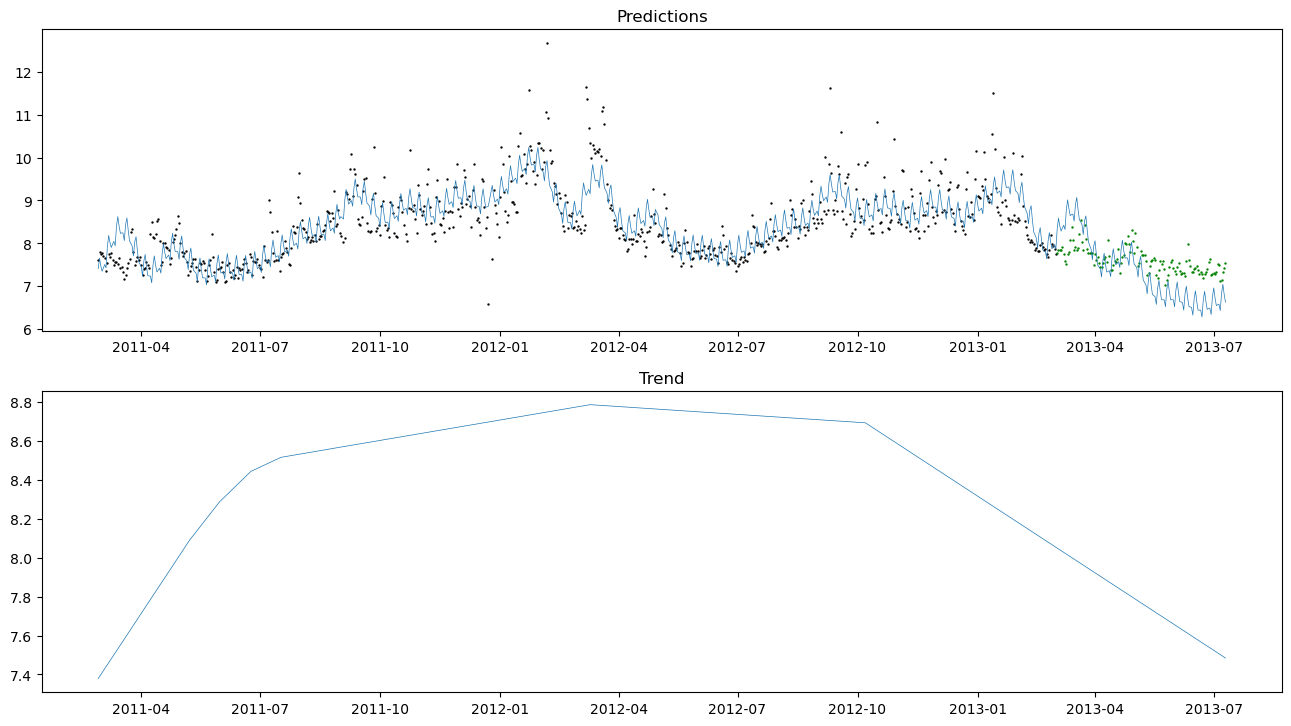

In [242]:
window = 730
horizon = 130
start = randint(0, len(df) - window - horizon - 1)

my_model = MyProphet()
my_model.fit(df[start:start + window])
preds = my_model._predict_map(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


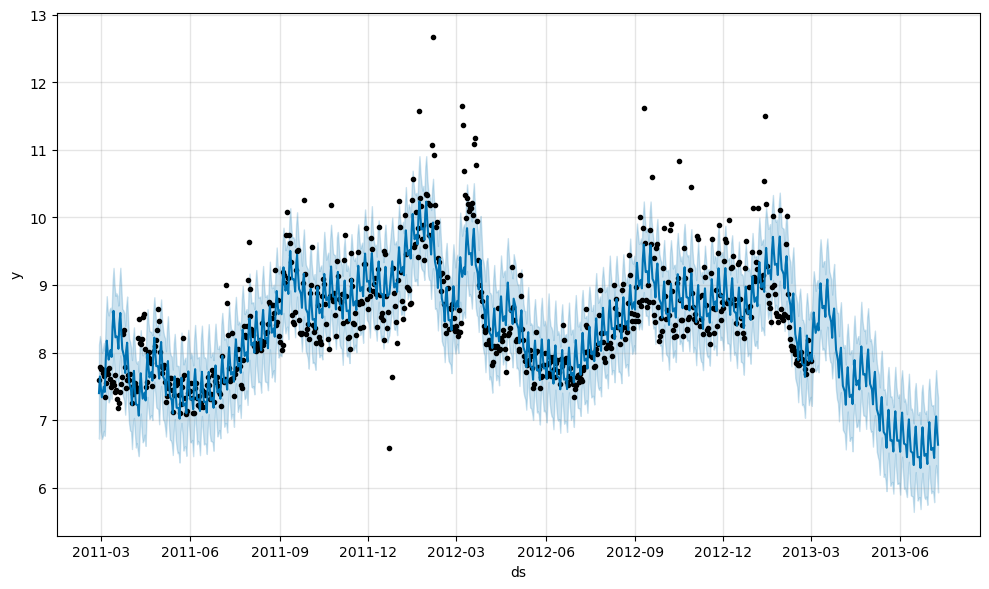

In [243]:
model = Prophet()
model.fit(df[start:start + window])
future = model.make_future_dataframe(periods=horizon, include_history=True)
forecast = model.predict(future)
fig = model.plot(forecast)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 137 seconds.
Sampling: [obs]


Output()

/tmp/ipykernel_23064/3673355540.py:132: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


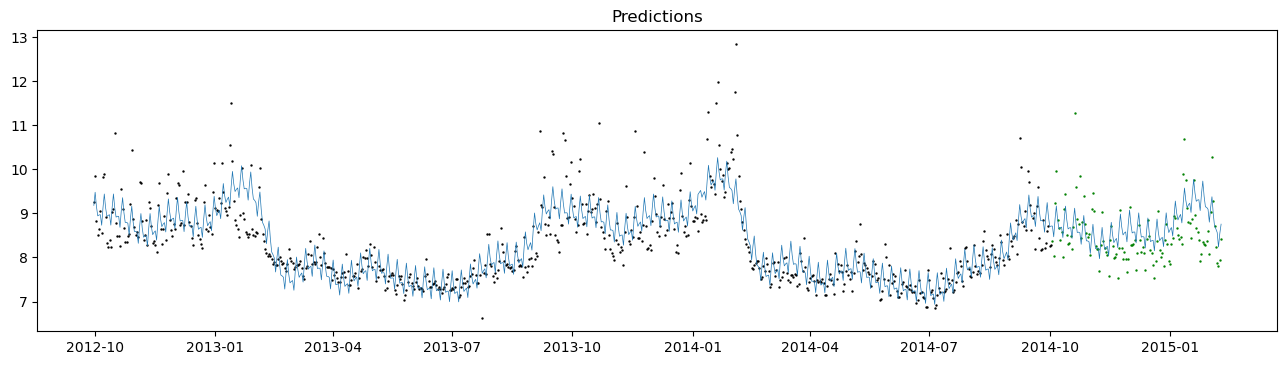

In [102]:
model = MyProphet(mcmc_samples=1000)
model.fit(df[start:start + window])
mcmc_preds = model._predict_mcmc(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

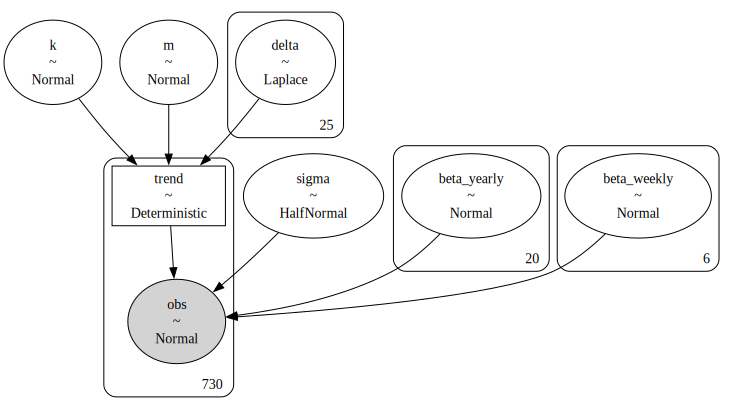

In [103]:
pm.model_to_graphviz(model.model)

/tmp/ipykernel_23064/1509483797.py:144: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


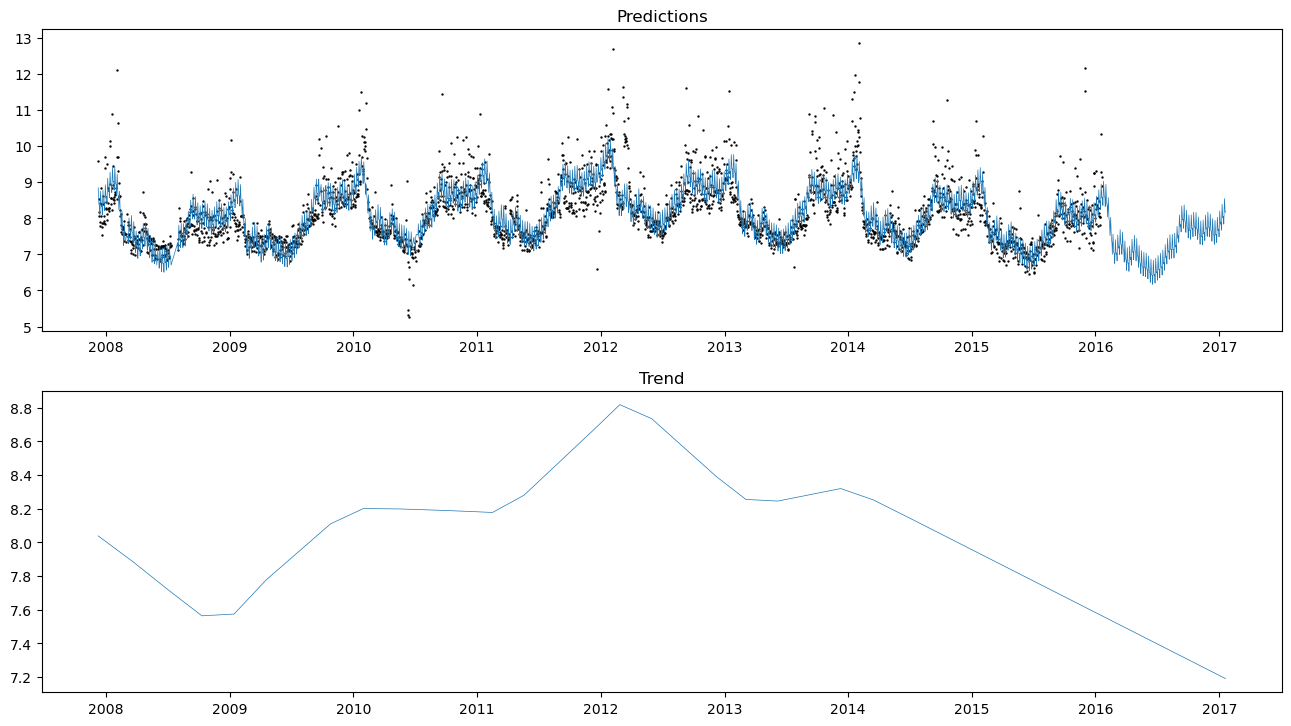

In [244]:
my_model = MyProphet()
my_model.fit(df)
preds = my_model._predict_map(365, plot=True)

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime o

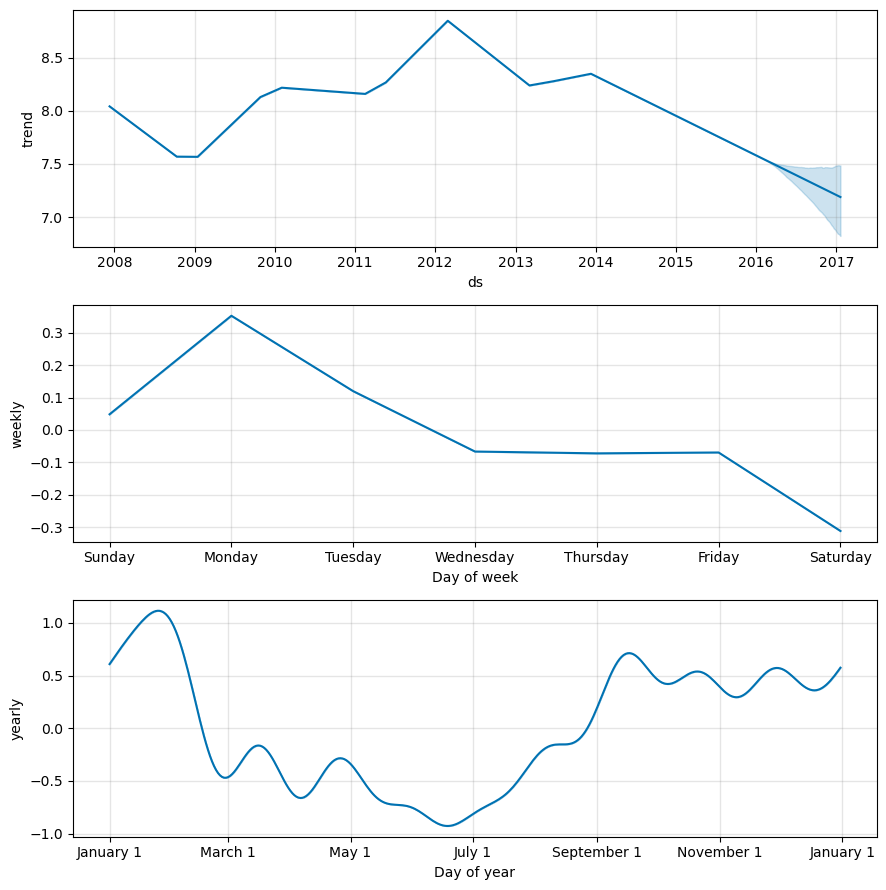

In [226]:
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=365, include_history=True)
yhat = model.predict(future)
fig = model.plot_components(yhat)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 813 seconds.
Sampling: [obs]


Output()

/tmp/ipykernel_23064/3673355540.py:132: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


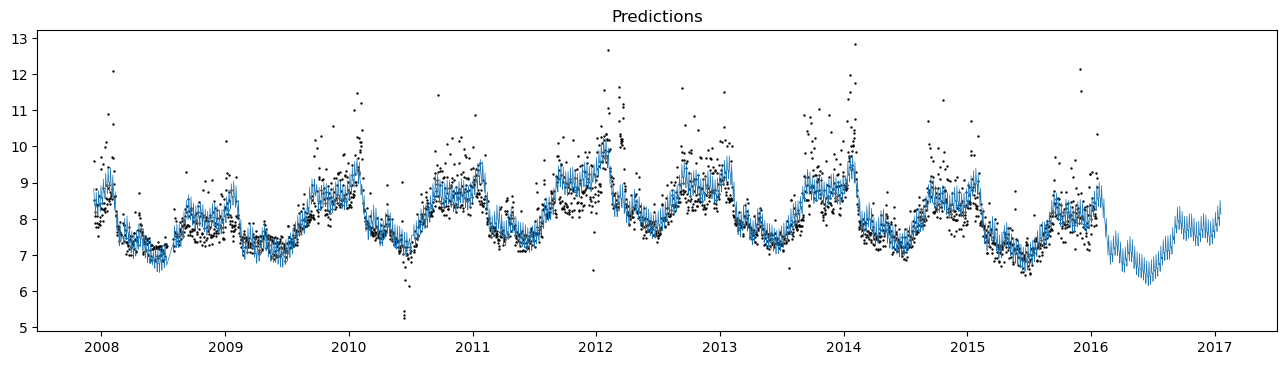

In [105]:
model = MyProphet(mcmc_samples=1000)
model.fit(df)
preds = model._predict_mcmc(365, plot=True)

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'beta_yearly'}>,
        <Axes: title={'center': 'beta_yearly'}>],
       [<Axes: title={'center': 'beta_weekly'}>,
        <Axes: title={'center': 'beta_weekly'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'trend'}>,
        <Axes: title={'center': 'trend'}>]], dtype=object)

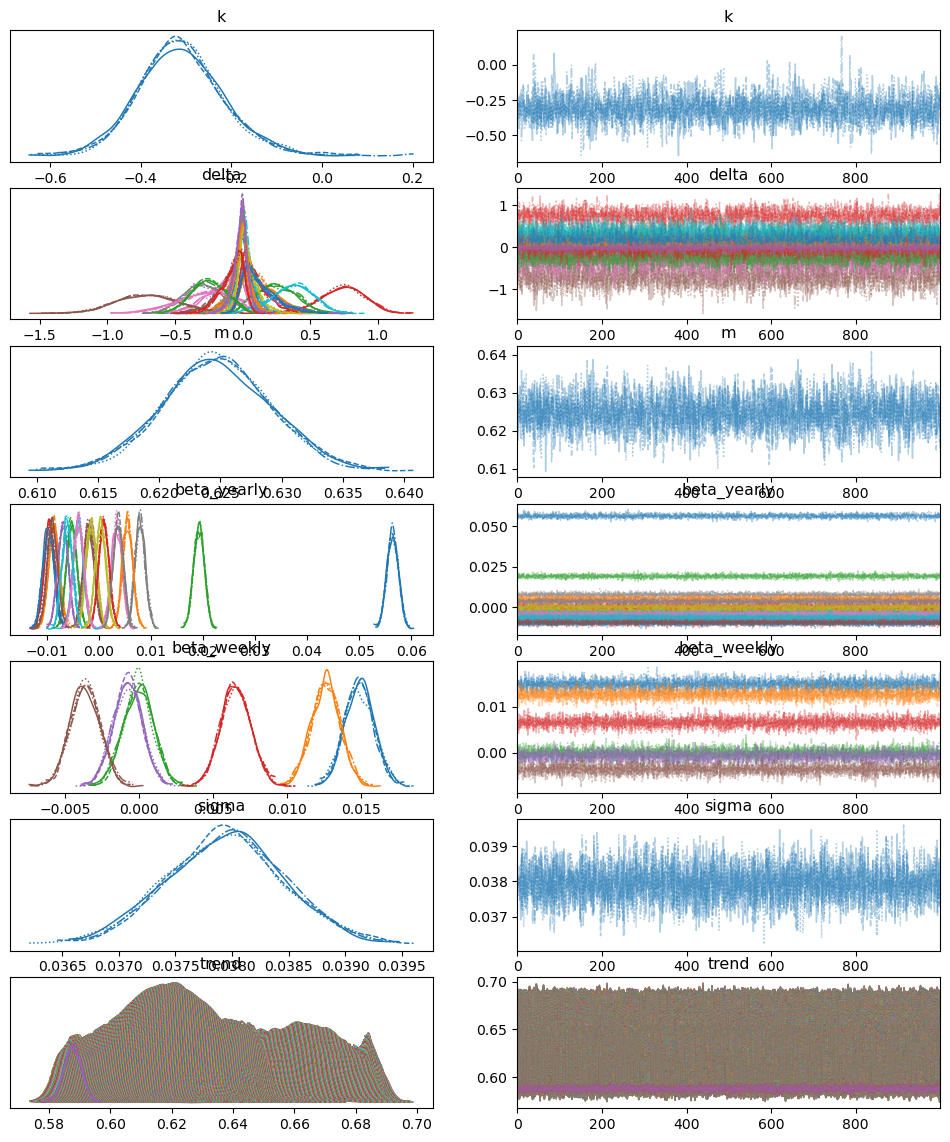

In [106]:
pm.plot_trace(model.trace)

In [120]:
model_wrapper = MyProphetWrapper()
prophet_extended_preds = model_wrapper.test_prophet(df, extend_window=True)
prophet_extended_preds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [06:05<00:00,  1.00s/it]


,horizon,mse,rmse,mae,mape
0,1,0.307345,0.554387,0.401853,0.046985
1,2,0.315383,0.561590,0.407574,0.047648
2,3,0.322017,0.567465,0.412079,0.048247
3,4,0.331447,0.575714,0.417853,0.048912
4,5,0.336436,0.580031,0.420993,0.049277
...,...,...,...,...,...
360,361,1.100175,1.048892,0.835052,0.102521
361,362,1.100399,1.048999,0.834881,0.102538
362,363,1.095564,1.046692,0.833512,0.102474
363,364,1.099178,1.048417,0.836139,0.102849


In [121]:
prophet_preds = model_wrapper.test_prophet(df, extend_window=False)
prophet_preds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [05:58<00:00,  1.02it/s]


,horizon,mse,rmse,mae,mape
0,1,0.310349,0.557090,0.409990,0.048283
1,2,0.329031,0.573613,0.423143,0.049836
2,3,0.343626,0.586196,0.432513,0.051037
3,4,0.358261,0.598549,0.442182,0.052173
4,5,0.368531,0.607067,0.448885,0.052973
...,...,...,...,...,...
360,361,2.355649,1.534812,1.146263,0.140264
361,362,2.364379,1.537654,1.147494,0.140490
362,363,2.370242,1.539559,1.147800,0.140673
363,364,2.397023,1.548232,1.153333,0.141468


In [122]:
my_prophet_preds = model_wrapper.test_my_prophet(df)
my_prophet_preds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [06:03<00:00,  1.00it/s]


,horizon,mse,rmse,mae,mape
0,1,0.321305,0.566837,0.416881,0.049123
1,2,0.338100,0.581464,0.428980,0.050565
2,3,0.349865,0.591494,0.436636,0.051579
3,4,0.367605,0.606305,0.447852,0.052898
4,5,0.375788,0.613016,0.453163,0.053524
...,...,...,...,...,...
360,361,3.073584,1.753164,1.343658,0.164653
361,362,3.060828,1.749522,1.337382,0.164075
362,363,3.100929,1.760945,1.342789,0.164820
363,364,3.146560,1.773855,1.354891,0.166250


In [ ]:
model_wrapper = MyProphetWrapper()
my_prophet_simple_preds = model_wrapper.test_my_prophet(df, update_priors_days=0)
my_prophet_simple_preds

  0%|▌                                                                                                                                                                        | 6/1809 [00:13<1:18:37,  2.62s/it]

In [ ]:
model_wrapper = MyProphetWrapper()
prophet_simple_preds = model_wrapper.test_prophet(df)
prophet_simple_preds

In [128]:
model_wrapper = MyProphetWrapper(mcmc_samples=1000)
my_prophet_mcmc_preds = model_wrapper.test_my_prophet(df, update_priors_days=30)
my_prophet_mcmc_preds

  0%|                                                                                                                                                                                   | 0/1809 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 203 seconds.
Sampling: [obs]


Output()

  2%|██▊                                                                                                                                                                       | 30/1809 [04:16<45:19,  1.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 160 seconds.
Sampling: [obs]


Output()

  3%|█████▌                                                                                                                                                                  | 60/1809 [07:49<1:17:18,  2.65s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.
Sampling: [obs]


Output()

  5%|████████▍                                                                                                                                                                 | 90/1809 [11:13<41:40,  1.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 174 seconds.
Sampling: [obs]


Output()

  7%|███████████                                                                                                                                                              | 119/1809 [15:00<40:17,  1.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 178 seconds.
Sampling: [obs]


Output()

  8%|██████████████                                                                                                                                                           | 150/1809 [18:56<38:16,  1.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 150 seconds.
Sampling: [obs]


Output()

 10%|████████████████▊                                                                                                                                                        | 180/1809 [22:24<35:03,  1.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.
Sampling: [obs]


Output()

 12%|███████████████████▌                                                                                                                                                     | 210/1809 [25:50<40:08,  1.51s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 191 seconds.
Sampling: [obs]


Output()

 13%|██████████████████████▍                                                                                                                                                  | 240/1809 [30:00<49:48,  1.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 225 seconds.
Sampling: [obs]


Output()

 15%|█████████████████████████▏                                                                                                                                               | 270/1809 [34:38<36:55,  1.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 172 seconds.
Sampling: [obs]


Output()

 17%|████████████████████████████                                                                                                                                             | 300/1809 [38:24<28:42,  1.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 154 seconds.
Sampling: [obs]


Output()

 18%|██████████████████████████████▊                                                                                                                                          | 330/1809 [41:55<34:04,  1.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.
Sampling: [obs]


Output()

 20%|█████████████████████████████████▋                                                                                                                                       | 360/1809 [45:11<30:25,  1.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 157 seconds.
Sampling: [obs]


Output()

 22%|████████████████████████████████████▍                                                                                                                                    | 390/1809 [48:45<29:31,  1.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 219 seconds.
Sampling: [obs]


Output()

 23%|███████████████████████████████████████▏                                                                                                                                 | 420/1809 [53:21<29:14,  1.26s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.
Sampling: [obs]


Output()

 25%|██████████████████████████████████████████                                                                                                                               | 450/1809 [56:48<39:40,  1.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 160 seconds.
Sampling: [obs]


Output()

 27%|████████████████████████████████████████████▎                                                                                                                          | 480/1809 [1:00:19<31:40,  1.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 152 seconds.
Sampling: [obs]


Output()

 28%|███████████████████████████████████████████████                                                                                                                        | 510/1809 [1:03:47<29:40,  1.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 170 seconds.
Sampling: [obs]


Output()

 30%|█████████████████████████████████████████████████▊                                                                                                                     | 540/1809 [1:07:36<29:04,  1.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.
Sampling: [obs]


Output()

 32%|████████████████████████████████████████████████████▌                                                                                                                  | 570/1809 [1:11:07<28:44,  1.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.
Sampling: [obs]


Output()

 33%|███████████████████████████████████████████████████████▍                                                                                                               | 600/1809 [1:14:27<25:14,  1.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.
Sampling: [obs]


Output()

 35%|██████████████████████████████████████████████████████████▏                                                                                                            | 630/1809 [1:17:44<28:02,  1.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 161 seconds.
Sampling: [obs]


Output()

 36%|████████████████████████████████████████████████████████████▉                                                                                                          | 660/1809 [1:21:21<37:53,  1.98s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 204 seconds.
Sampling: [obs]


Output()

 38%|███████████████████████████████████████████████████████████████▌                                                                                                       | 689/1809 [1:25:37<25:24,  1.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 205 seconds.
Sampling: [obs]


Output()

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                    | 720/1809 [1:30:00<26:05,  1.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 134 seconds.
Sampling: [obs]


Output()

 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                 | 750/1809 [1:33:13<24:38,  1.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 213 seconds.
Sampling: [obs]


Output()

 43%|████████████████████████████████████████████████████████████████████████                                                                                               | 780/1809 [1:37:42<24:36,  1.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 188 seconds.
Sampling: [obs]


Output()

 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                            | 810/1809 [1:41:45<23:22,  1.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 151 seconds.
Sampling: [obs]


Output()

 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                         | 840/1809 [1:45:11<22:59,  1.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 193 seconds.
Sampling: [obs]


Output()

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 870/1809 [1:49:20<32:47,  2.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 236 seconds.
Sampling: [obs]


Output()

 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                    | 900/1809 [1:54:10<21:13,  1.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 221 seconds.
Sampling: [obs]


Output()

 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 930/1809 [1:58:47<16:10,  1.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 193 seconds.
Sampling: [obs]


Output()

 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 960/1809 [2:02:58<18:35,  1.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 192 seconds.
Sampling: [obs]


Output()

 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 990/1809 [2:07:04<18:28,  1.35s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 217 seconds.
Sampling: [obs]


Output()

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1020/1809 [2:11:38<18:30,  1.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 235 seconds.
Sampling: [obs]


Output()

 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1050/1809 [2:16:32<20:22,  1.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 260 seconds.
Sampling: [obs]


Output()

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1080/1809 [2:21:42<15:03,  1.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 152 seconds.
Sampling: [obs]


Output()

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1110/1809 [2:25:11<11:05,  1.05it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.
Sampling: [obs]


Output()

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1140/1809 [2:29:01<15:56,  1.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 228 seconds.
Sampling: [obs]


Output()

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1169/1809 [2:33:47<15:07,  1.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 135 seconds.
Sampling: [obs]


Output()

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1200/1809 [2:36:57<13:07,  1.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.
Sampling: [obs]


Output()

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1230/1809 [2:40:29<13:13,  1.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 221 seconds.
Sampling: [obs]


Output()

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1260/1809 [2:45:07<14:53,  1.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 207 seconds.
Sampling: [obs]


Output()

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1290/1809 [2:49:26<12:16,  1.42s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 192 seconds.
Sampling: [obs]


Output()

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1320/1809 [2:53:33<08:43,  1.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 172 seconds.
Sampling: [obs]


Output()

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1350/1809 [2:57:21<10:47,  1.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 161 seconds.
Sampling: [obs]


Output()

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1380/1809 [3:01:02<10:15,  1.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 219 seconds.
Sampling: [obs]


Output()

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1410/1809 [3:05:38<09:33,  1.44s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 237 seconds.
Sampling: [obs]


Output()

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1440/1809 [3:10:32<09:11,  1.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
Sampling: [obs]


Output()

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1470/1809 [3:13:53<12:31,  2.22s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 139 seconds.
Sampling: [obs]


Output()

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1500/1809 [3:17:03<07:23,  1.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 179 seconds.
Sampling: [obs]


Output()

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1530/1809 [3:20:59<06:20,  1.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
Sampling: [obs]


Output()

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1560/1809 [3:24:06<05:47,  1.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.
Sampling: [obs]


Output()

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1590/1809 [3:27:19<03:27,  1.05it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 135 seconds.
Sampling: [obs]


Output()

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1620/1809 [3:30:26<04:07,  1.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 137 seconds.
Sampling: [obs]


Output()

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1650/1809 [3:33:36<04:38,  1.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.
Sampling: [obs]


Output()

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1680/1809 [3:36:53<01:58,  1.09it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 138 seconds.
Sampling: [obs]


Output()

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1710/1809 [3:40:10<02:19,  1.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 129 seconds.
Sampling: [obs]


Output()

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1740/1809 [3:43:17<01:34,  1.37s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 150 seconds.
Sampling: [obs]


Output()

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1770/1809 [3:46:41<00:54,  1.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 176 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [obs]


Output()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1800/1809 [3:50:31<00:11,  1.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 179 seconds.
Sampling: [obs]


Output()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [06:05<00:00,  1.00s/it]


,horizon,mse,rmse,mae,mape
0,1,0.322450,0.567847,0.419267,0.049463
1,2,0.345040,0.587401,0.432790,0.051044
2,3,0.354348,0.595271,0.439873,0.051960
3,4,0.373059,0.610786,0.448811,0.053016
4,5,0.385026,0.620505,0.458992,0.054205
...,...,...,...,...,...
360,361,3.168142,1.779927,1.347572,0.164740
361,362,3.175776,1.782071,1.341625,0.163970
362,363,3.195226,1.787520,1.342710,0.164368
363,364,3.268138,1.807799,1.363990,0.167005


In [132]:
my_prophet_simple_preds.describe()

,horizon,mse,rmse,mae,mape
count,365.000000,365.000000,365.000000,365.000000,365.000000
mean,183.000000,1.419242,1.153143,0.868779,0.104062
std,105.510663,0.715999,0.299580,0.225187,0.027559
min,1.000000,0.310040,0.556812,0.410259,0.048323
25%,92.000000,0.861810,0.928337,0.720071,0.086988
50%,183.000000,1.243982,1.115339,0.817018,0.096625
75%,274.000000,1.871923,1.368182,1.025991,0.122142
max,365.000000,3.171311,1.780818,1.371200,0.168419


In [133]:
prophet_preds.describe()

,horizon,mse,rmse,mae,mape
count,365.000000,365.000000,365.000000,365.000000,365.000000
mean,183.000000,1.222504,1.080336,0.798024,0.095236
std,105.510663,0.514320,0.235649,0.163485,0.019951
min,1.000000,0.310349,0.557090,0.409990,0.048283
25%,92.000000,0.831506,0.911869,0.710167,0.085796
50%,183.000000,1.124022,1.060199,0.773592,0.092040
75%,274.000000,1.557424,1.247968,0.901505,0.106492
max,365.000000,2.431661,1.559378,1.160773,0.142491


In [165]:
model = Prophet()
transformed = model.preprocess(df)
transformed.t

0       0.000000
1       0.000337
2       0.000675
3       0.001012
4       0.001350
          ...   
2900    0.998650
2901    0.998988
2902    0.999325
2903    0.999663
2904    1.000000
Name: t, Length: 2905, dtype: float64

In [189]:
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=365, include_history=True)
forecast = model.predict(future)

In [193]:
forecast["yhat"][:len(df)]

0       8.844650
1       8.593182
2       8.388997
3       8.366910
4       8.354874
          ...   
2900    8.228526
2901    8.609330
2902    8.933145
2903    8.719103
2904    8.549950
Name: yhat, Length: 2905, dtype: float64

In [194]:
mean_absolute_percentage_error(df["y"], forecast["yhat"][:len(df)])

0.039984054963658866

In [195]:
preds

,ds,t,trend,yearly,weekly,yhat
0,2007-12-10,0.000000,8.060380,0.454215,0.352259,8.866854
1,2007-12-11,0.000337,8.058749,0.436979,0.119708,8.615435
2,2007-12-12,0.000675,8.057117,0.420667,-0.066719,8.411065
3,2007-12-13,0.001012,8.055486,0.405724,-0.072255,8.388954
4,2007-12-14,0.001350,8.053854,0.392554,-0.069586,8.376822
...,...,...,...,...,...,...
3265,2017-01-15,1.121836,7.276861,0.970009,0.048237,8.295107
3266,2017-01-16,1.122173,7.276092,0.992025,0.352259,8.620376
3267,2017-01-17,1.122511,7.275324,1.013111,0.119708,8.408143
3268,2017-01-18,1.122848,7.274555,1.033065,-0.066719,8.240901


In [199]:
mean_absolute_percentage_error(df["y"], preds["yhat"][:len(df)])

0.04010759742315557